In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string, re
import sys, zipfile
from collections import Counter
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers import Bidirectional, CuDNNLSTM
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.corpus import names, stopwords, words
from nltk.stem import WordNetLemmatizer
from scipy import stats
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.insert(0, './code/')
from text_cleaning  import TextClean

%matplotlib inline

glove = "../glove/glove.840B.300d.zip"
embedding_dimension = 300
max_words = 20000
val_split = 0.1

Using TensorFlow backend.


In [2]:
a = TextClean('.', app_name='temple_')
# a.multi_process()
# a.combine_products()

In [3]:
import json
X = []
y = []

with open('./data/temp_pre/temple__12.json') as f:
    j = json.load(f)
    [X.append(x['cleaned_text']) for x in j]
    [y.append(x['stars']) for x in j]

In [4]:
len(X), len(y)

(450522, 450522)

In [5]:
X[3], y[3]

('game bad jump chasing cloths hate pouting face pouting face pouting face pouting face pouting face pouting face pouting face pouting face',
 '1 star')

In [6]:
cnts = Counter(y)
cnts = dict(sorted(cnts.items(), key=lambda x: x[1]))

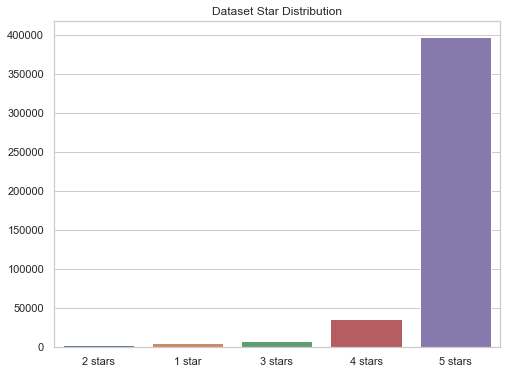

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=list(cnts.keys()), y=list(cnts.values()))
ax.set_title('Dataset Star Distribution')
plt.show()

In [8]:
X_, y_ = a.even_sample(X, y)

In [9]:
y_ = [int(re.search(r'\d+', x).group()) for x in y_]

In [10]:
print(Counter(y_))

Counter({3: 3712, 4: 3712, 5: 3712, 1: 3712, 2: 2712})


In [11]:
sequence_length = max([len(x) for x in X_]) + 1
tokenizer = Tokenizer(num_words=max_words, split=' ', oov_token='<unk>', filters=' ')
tokenizer.fit_on_texts(X_)

X = tokenizer.texts_to_sequences(X_)
X = pad_sequences(X, sequence_length)

In [12]:
y = np.array(y_)
y_l = to_categorical(np.asarray(y))
y_l = np.delete(y_l, 0, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_l, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 1756


In [13]:
vocab_size = min(max_words, len(tokenizer.word_index)) + 1

def glove(glove_dir, wordindex):      
    embedding_weights = {}
    count_all_words = 0 
    with zipfile.ZipFile(glove_dir) as z:
        with z.open("glove.840B.300d.txt") as f:
            for line in f:
                vals = line.split()
                word = str(vals[0].decode("utf-8")) 
                if word in wordindex:
                    count_all_words+=1
                    coefs = np.asarray(vals[1:], dtype='float32')
                    coefs/=np.linalg.norm(coefs) 
                    embedding_weights[word] = coefs
                if count_all_words==len(wordindex) - 1:
                    break
    return embedding_weights 

embeddings_index = glove("./glove/glove.840B.300d.zip", tokenizer.word_index)

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(300)

In [32]:
model = Sequential([
    Embedding(vocab_size, embedding_dimension, embeddings_initializer=Constant(embedding_matrix),
    input_length=sequence_length,trainable=False),
    SpatialDropout1D(0.3),
    Bidirectional(CuDNNLSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(CuDNNLSTM(64)),
    Dropout(0.5),
    Dense(units=5, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2883, 300)         3160500   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 2883, 300)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 2883, 128)         187392    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2883, 128)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               99328     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total para

In [33]:
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
save_best = ModelCheckpoint('reviews_lstm.hdf', save_best_only=True, 
                           monitor='val_loss', mode='min')
history = model.fit(X_train, y_train, 
                    epochs=12, 
                    batch_size=batch_size, 
                    callbacks=[early_stopping,save_best],
                    verbose=1, validation_split=0.1)

Train on 14223 samples, validate on 1581 samples
Epoch 1/12
14223/14223 [==============================] - 201s 14ms/step - loss: 1.4820 - categorical_accuracy: 0.3505 - val_loss: 1.4145 - val_categorical_accuracy: 0.3978
Epoch 2/12
14223/14223 [==============================] - 199s 14ms/step - loss: 1.3965 - categorical_accuracy: 0.4105 - val_loss: 1.3967 - val_categorical_accuracy: 0.4105
Epoch 3/12
14223/14223 [==============================] - 199s 14ms/step - loss: 1.3690 - categorical_accuracy: 0.4267 - val_loss: 1.3923 - val_categorical_accuracy: 0.4130
Epoch 4/12
14223/14223 [==============================] - 199s 14ms/step - loss: 1.3524 - categorical_accuracy: 0.4338 - val_loss: 1.3714 - val_categorical_accuracy: 0.4238
Epoch 5/12
14223/14223 [==============================] - 208s 15ms/step - loss: 1.3335 - categorical_accuracy: 0.4409 - val_loss: 1.3730 - val_categorical_accuracy: 0.4263
Epoch 6/12
14223/14223 [==============================] - 205s 14ms/step - loss: 1.323

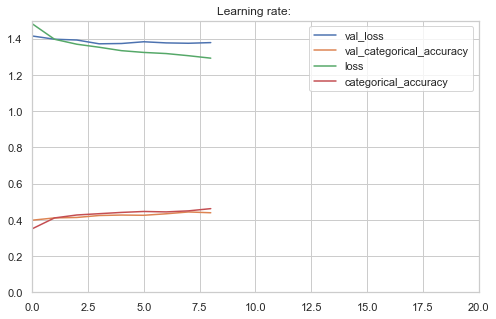

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.axis([0, 20, 0, 1.5])
plt.title("Learning rate: ")
plt.grid(True)
plt.show()

Text(89.18, 0.5, 'label actual')

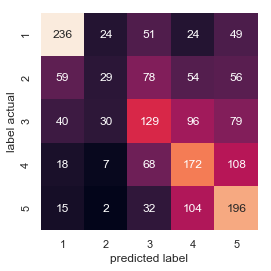

In [35]:
preds = model.predict(X_test)
y_classes = [np.argmax(y_test, axis=None, out=None) for y in y_test]
matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5])

plt.xlabel('predicted label')
plt.ylabel('label actual')

In [36]:
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63       384
           1       0.32      0.11      0.16       276
           2       0.36      0.34      0.35       374
           3       0.38      0.46      0.42       373
           4       0.40      0.56      0.47       349

   micro avg       0.43      0.43      0.43      1756
   macro avg       0.42      0.42      0.40      1756
weighted avg       0.43      0.43      0.42      1756



In [37]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
info = {
    'tokenizer':'tokenizer.pickle',
    'model':'reviews_lstm.hdf',
    'max_sequence':sequence_length,
    'max_words':max_words,
    'vocab_size':vocab_size
}

import json

with open('project_info.json', 'w') as outfile:
    json.dump(info, outfile)

In [39]:
import keras
model = keras.models.load_model("./scoring_service/models/"+info['model'])
model.predict(X_train[0:1])

array([[0.59252924, 0.22609615, 0.13238469, 0.03731937, 0.0116705 ]],
      dtype=float32)